# Radio Light Curve Module

**Lecturer:** Poonam Chandra<br>
**Jupyter Notebook Authors:** David Kaplan & Cameron Hummels

This is a Jupyter notebook lesson taken from the GROWTH Winter School 2018.  For other lessons and their accompanying lectures, please see: http://growth.caltech.edu/growth-astro-school-2018-resources.html

## Objective
Produce and analyze radio light curve data, fitting a broken power law to it.

## Key steps
- Plot the radio light curve
- Determine its spectral index
- Scale the data based on its spectral index
- Fit the data with a power law
- Fit the data with a broken power law with a turnover

## Required dependencies

See GROWTH school webpage for detailed instructions on how to install these modules and packages.  Nominally, you should be able to install the python modules with `pip install <module>`.  The external astromatic packages are easiest installed using package managers (e.g., `rpm`, `apt-get`).

### Python modules
* python 3
* astropy
* numpy
* scipy
* matplotlib
* emcee
* corner

### External packages
None

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
from astropy.io import ascii
import corner
import os
from timeit import default_timer as timer
import matplotlib.colors as colors
import matplotlib.cm as cmx
from scipy.optimize import least_squares, curve_fit
from scipy.stats import f

In [2]:
def load_data(filename='radio_lightcurve.dat'):
    data = ascii.read(filename)
    return data
os.chdir('data')
data = load_data()

# Make a plot of the radio lightcurve
Make a log-log plot of the flux density as a function of time. Make sure to modularise your code so that we can re-use parts of it later on. For bonus points use different markers for each telescope, and use a colour scale to denote the observation frequency.

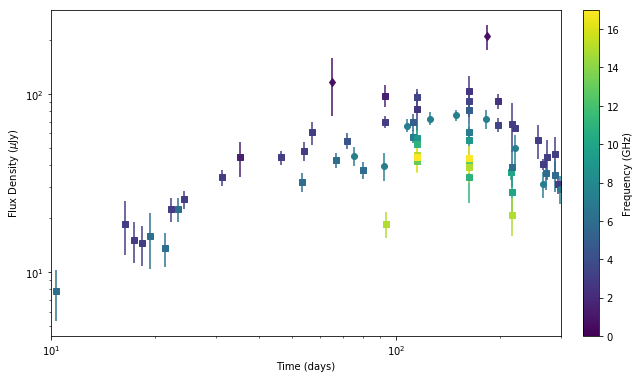

In [3]:
def plot_data(ax, sm, data, scaled=False, **kwargs):
    telescope_marker_dict = {'VLA':'s', 'ATCA':'o', 'GMRT':'d'}
    
    
    for row in data:
        freq = row['frequency']
        colorval = sm.to_rgba(freq)
        
        telescope = row['telescope']
        marker = telescope_marker_dict[telescope]
        
        if scaled:
            flux = row['scaled_flux']
            rms = row['scaled_rms']
        else:
            flux = row['flux']
            rms = row['rms']
        
        ax.errorbar(row['delta_t'], flux, rms, linestyle='', marker=marker, c=colorval, **kwargs)
    return

def cmap_setup(cmap='viridis', min_freq=0, max_freq=17):
    freq_cmap = plt.cm.get_cmap(cmap)
    
    cNorm  = colors.Normalize(vmin=min_freq, vmax=max_freq)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)
    sm = scalarMap
    sm._A = []
    
    return sm    
    
def make_plot(data, scaled=False, model=None, params=None, tvals=np.arange(10,400), plot_models=False):
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111)
    
    sm = cmap_setup()
    plot_data(ax, sm, data, scaled=scaled)
    
    cbar = fig.colorbar(sm,fraction=0.046, pad=0.04)
    cbar.set_label('Frequency (GHz)')
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    ax.set_xlabel('Time (days)')
    if scaled:
        ax.set_ylabel('Scaled Flux Density ($\mu$Jy)')
    else:
        ax.set_ylabel('Flux Density ($\mu$Jy)')
        
    if model:
        plot_model(model, params, tvals, ax)
    
    if plot_models:
        plot_physical_models(ax)
    
    ax.set_xlim(10,300)
    
make_plot(data)

# Determining the spectral index
Write a function to take a subset of the data and calculate the spectral index and its uncertainty. Using multi-band observation at 162 days post-merger calculate the spectral index.

In [4]:
def calc_power_law(freq,S0,alpha):
    S = S0 * (freq) ** alpha
    return S

def alpha_calc(data):
    freqs = data['frequency']
    flux = data['flux']
    flux_errs = data['rms']
    
    popt, pcov = curve_fit(calc_power_law, freqs, flux ,sigma=flux_errs, p0=(50,-0.61),absolute_sigma=True)
    
    alpha = popt[1]
    alpha_err = np.sqrt(np.diag(pcov))[1]
    
    return alpha, alpha_err

In [5]:
sel_data = data[data['delta_t'] == 162.89]

# alpha, alpha_err = alpha_calc(sel_data)

# print("alpha = %.1f+/-%.1f"%(alpha, alpha_err))

## Scaling the data based on the spectral Index
Write a function to take the observed data and scale it to a specific frequency based on an estimated spectral index. Don't forget to include uncertainties! You should add two columns to your data table called "scaled_flux" and "scaled_rms"

In [6]:
def scale_data(data, alpha, alpha_err, ref_freq=3.0):
    f_scale = (ref_freq/data['frequency'])**alpha
    rms_scale = np.abs(f_scale*np.log(ref_freq/data['frequency'])*alpha_err)
    
    scaled_flux = data['flux'] * f_scale
    scaled_rms = np.abs(scaled_flux) * np.sqrt((data['rms']/data['flux'])**2 + (rms_scale/f_scale)**2)
    
    data['scaled_flux'] = scaled_flux
    data['scaled_rms'] = scaled_rms
    
    return data

Modify your plot_data() and make_plot() functions to add a keyword parameter "scaled" that is by default False. If scaled=True, plot_data() should plot the scaled data instead of the observed data.

Scale the data to 3 GHz based on your estimated spectral index and associated uncertainty, then plot the scaled lightcurve

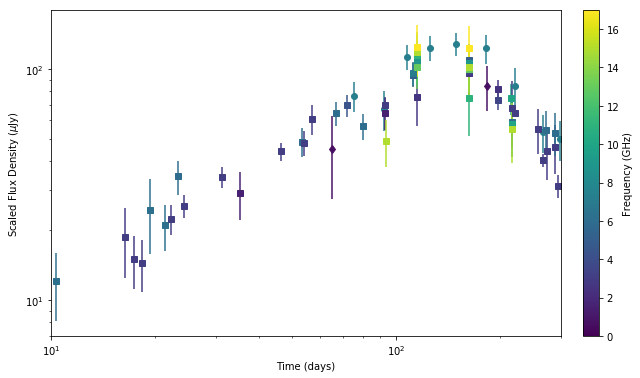

In [7]:
data = scale_data(data, -0.6,0.1)
make_plot(data, scaled=True)

# Fitting the data
We now want to characterise the radio lightcurve. You should be able to see that it initially rises according to a power law, peaks somewhere between 100 and 200 days post-merger and then declines according to a different power law.

However, when we published the first paper demonstrating evidence of a turnover we only had observations up to 200 days post-merger. We will now determine evidence for a turnover using that subset of data.

Create a new table called tdata with the data up to 200 days post-merger and plot the data using your make_plot() function.

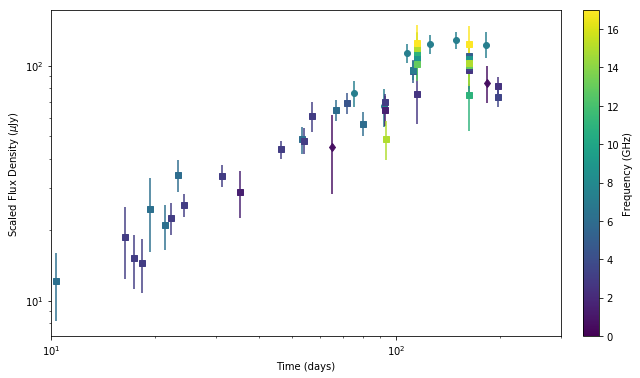

In [8]:
data = load_data()
data = scale_data(data, -0.6,0.05)
tdata = data[data['delta_t'] < 200]

make_plot(tdata, scaled=True)

We can fit this data with a "smoothed broken power law", which combines two power laws with a smoothing parameter around the break point. One functional form of this is given by

$S(t) = F_{\rm peak} \left[ \left(\dfrac{t}{t_{\rm peak}}\right)^{-s\delta_1} + \left(\dfrac{t}{t_{\rm peak}}\right)^{-s\delta_2}\right]^{-1/s}$

Write a function smooth_broken_power_law() that outputs a smoothed broken power law that also scales based on frequency and spectral index

In [9]:
def smooth_broken_power_law(t, nu, F_peak, t_peak, delta_1, delta_2, alpha, log_s, nu0=3.0):
    s = 10**log_s

    return (nu/nu0)**alpha * F_peak * ((t/t_peak)**(-s*delta_1) + (t/t_peak)**(-s*delta_2))**(-1.0/s)

## Determining evidence for a turnover

We now want to fit a smoothed broken power law to our data and see if there is evidence for a turnover in the radio lightcurve. In our paper we do this via a parameter grid-search to minimise $\chi^2$. 

Here we will perform an MCMC fit using the emcee package, to determine lightcurve parameters and the spectral index of the source. First you will need to write 3 functions that define your Probability, Prior and Likelihood.

We will use a uniform prior with $\delta_1>0$ (since we require the lightcurve to initially rise), $0<t_{\rm peak}<300$ (since our data only covers the period up to 200 days) and $s<100$. The parameters will be passed to the function via a tuple.

In [10]:
def lnprior(theta):
    F_peak, t_peak, delta_1, delta_2, alpha, log_s = theta

    if 0.0 < t_peak < 300.0 and delta_1 > 0.0 and log_s < 3:
        return 0.0
    
    else:
        return -np.inf

We will now write a likelihood function that takes the lightcurve parameters inside the tuple theta, along with the observed data.

In [11]:
def lnlike(theta, t, nu, S, S_err):
    F_peak, t_peak, delta_1, delta_2, alpha, log_s = theta

    model = smooth_broken_power_law(t, nu, F_peak, t_peak, delta_1, delta_2, alpha, log_s)
    inv_sigma2 = 1.0/S_err**2

    return -0.5*(np.sum((S-model)**2*inv_sigma2 - np.log(inv_sigma2)))

Now write a function to calculate the marginal probability using the lnlike() and lnprior() functions you calculated above

In [12]:
def lnprob(theta, t, nu, S, S_err):
    lp = lnprior(theta)

    if not np.isfinite(lp):
        return -np.inf

    return lp + lnlike(theta, t, nu, S, S_err)

We will now fit the data using the emcee package. The function get_starting_pos() provided below will set up an array of walker starting positions for given lightcurve parameters. Examine the lightcurve and estimate some reasonable values for these parameters and add them to the function.

Now write a function called run_mcmc() that will load the observed data, take the starting position and then run the emcee Ensemple Sampler. Use a small number of iterations and walkers initially (100/20) to see how long the code takes to run on your laptop. Then increase both parameters to a larger number so that the algorithm takes ~90 seconds to run.

In [13]:
def get_starting_pos(nwalkers, ndim=6):
    F_peak = 110
    t_peak = 150
    delta_1 = 0.8
    delta_2 = -2
    alpha = -0.6
    log_s = 1
    
    pos = [np.asarray([F_peak, t_peak, delta_1, delta_2, alpha, log_s]) + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
    
    return pos

In [14]:
def run_mcmc(data, niters=1000, nthreads=1, nwalkers=200, ndim=6):
    t = data['delta_t']
    nu = data['frequency']
    S = data['flux']
    S_err = data['rms']
    
    pos = get_starting_pos(nwalkers, ndim=ndim)
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(t, nu, S, S_err),threads=nthreads)
    
    start = timer()
    sampler.run_mcmc(pos, niters)
    end = timer()
    
    print("Computation time: %f s"%(end-start))
    
    return sampler

We now want to inspect our chain to see if our algorithm has converged to a reasonable solution. First, extract the chain from the sampler, and then write a function to make a figure showing how each walker moves around the parameter space. Your figure should have 6 subplots (1 for each dimension), iteration number on the x-axis and parameter value on the y-axis.

MCMC algorithms typically use a burn-in phase, where the sampler is moving towards the optimum solution and not yet accurately sampling the parameter space. Add a parameter chain_cut to your function that plots a vertical line at the end of the burn-in.

In [15]:
sampler = run_mcmc(tdata)
chain = sampler.chain

/home/chummels/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in power
  after removing the cwd from sys.path.
/home/chummels/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in power
  after removing the cwd from sys.path.


Computation time: 103.129886 s


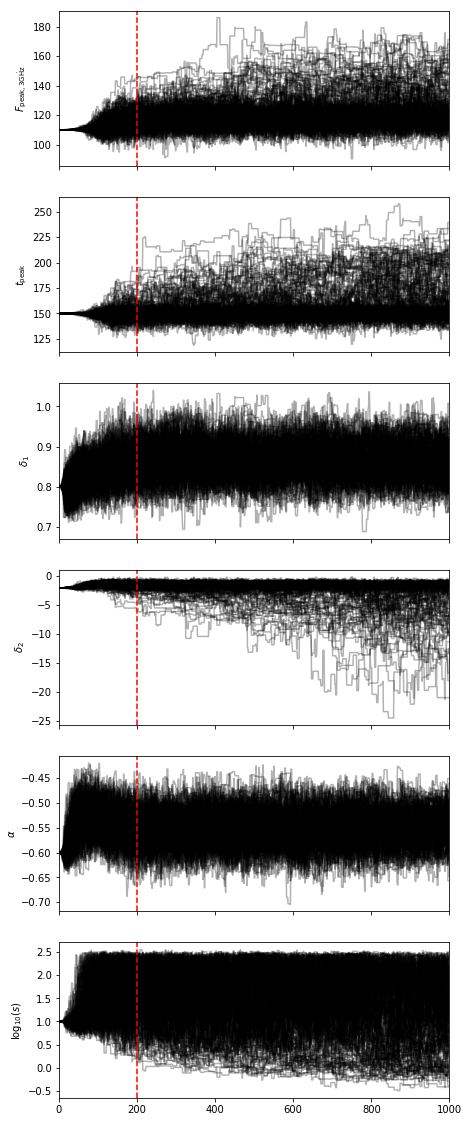

In [16]:
def make_chain_plot(chain, chain_cut):
    niters = chain.shape[1]
    ndim = chain.shape[2]

    fig, axes = plt.subplots(ndim,1,sharex=True)
    fig.set_size_inches(7, 20)
    
    param_names = ['$F_{{\\rm peak}, 3\.{\\rm GHz}}$', '$t_{{\\rm peak}}$','$\\delta_1$','$\\delta_2$', '$\\alpha$', '$\\log_{10}(s)$']

    for i, (ax,param_name) in enumerate(zip(axes,param_names)):
        ax.plot(chain[:,:,i].T,linestyle='-',color='k',alpha=0.3)
        ax.set_ylabel(param_name)
        ax.set_xlim(0,niters)
        ax.axvline(chain_cut,c='r',linestyle='--')

chain_cut = 200

make_chain_plot(chain, chain_cut)

Now that we know that our algorithm is converging, and we know how long the burn-in takes we can begin to estimate parameters. The function below will make a corner plot from the good part of your chain.

In [17]:
good_chain = chain[:, chain_cut:, :]

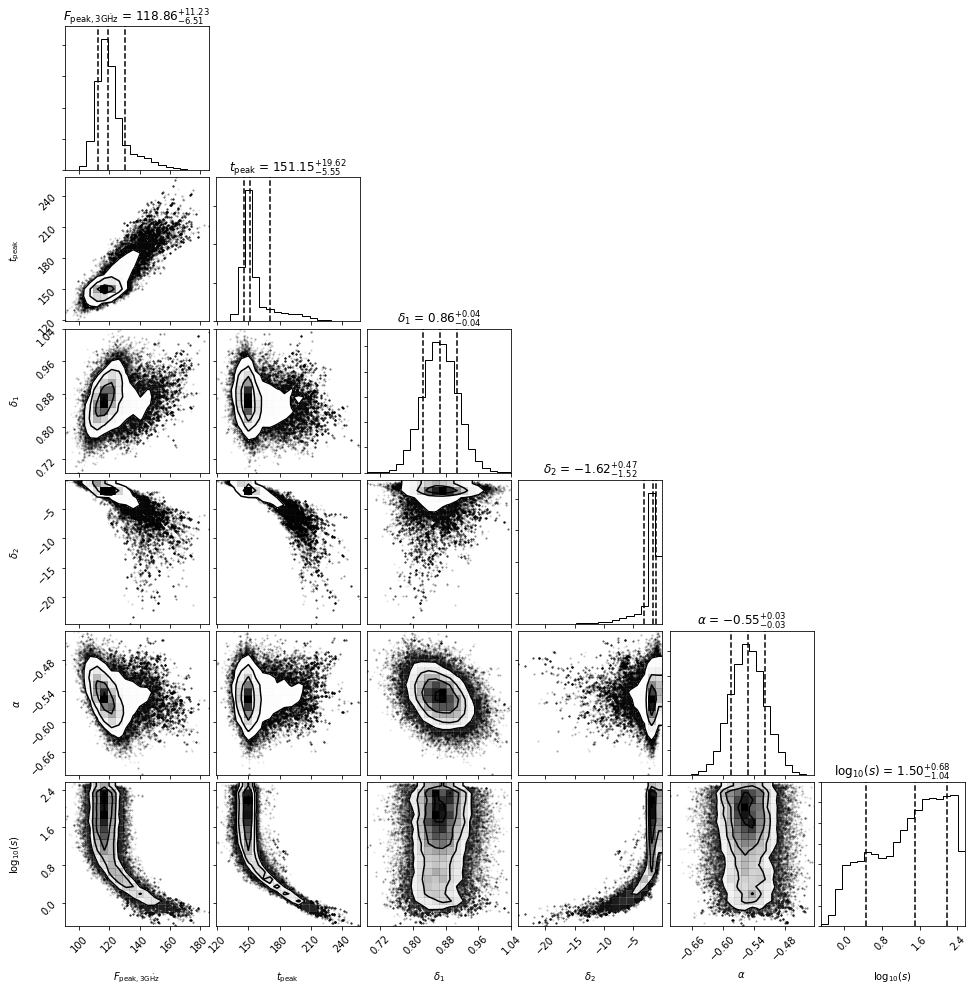

In [18]:
def make_corner_plot(good_chain, savefile='corner.png'):
    param_names = ['$F_{{\\rm peak}, 3\.{\\rm GHz}}$', '$t_{{\\rm peak}}$','$\\delta_1$','$\\delta_2$', '$\\alpha$', '$\\log_{10}(s)$']
    ndim = good_chain.shape[2]
    
    fig = corner.corner(good_chain.reshape((-1, ndim)), labels=param_names, quantiles=[0.16, 0.5, 0.84], show_titles=True)
    plt.savefig(savefile)

make_corner_plot(good_chain)

The function below will then extract the median and uncertainty (1 standard deviation) from the chain.

In [19]:
def get_best_params(chain):
    ndim = chain.shape[2]
    
    chain = chain.reshape((-1, ndim))
    vals = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(chain, [16, 50, 84],axis=0)))
    
    param_names = ['F_peak', 't_peak', 'delta_1', 'delta_2', 'alpha', 'log_s']
    
    param_dict = dict(zip(param_names,vals))
    
    return param_dict
    
    
best_params = get_best_params(good_chain)

Now write a function, calc_chi2(), that will calculate the $\chi^2$ for the fit. We will use this later to compare different lightcurve models

In [20]:
def calc_chi2(best_params, param_names, model, data, nu0=3.0):
    args = []
    for param in param_names:
        val = best_params[param][0]
        args.append(val)

    best_fit = model(data['delta_t'], nu0, *args)
    
    chi2 = np.sum((best_fit-data['scaled_flux'])**2/data['scaled_rms']**2)
    
    return chi2

param_names = ['F_peak', 't_peak', 'delta_1', 'delta_2', 'alpha', 'log_s']

chi2_best = calc_chi2(best_params, param_names, smooth_broken_power_law, tdata)
print(chi2_best)

56.79690008913517


We will now plot our best fit on top of the observational data.

Write a function plot_model() that takes in a function that calculates the model fit (in this case, our smooth_broken_power_law function), the best parameters, an array of values to plot the model for and a matplotlib axis to plot it on. Modify your make_plot function to take in an optional argument for the model to plot. If the model is supplied your make_plot() function should call your plot_model() function.

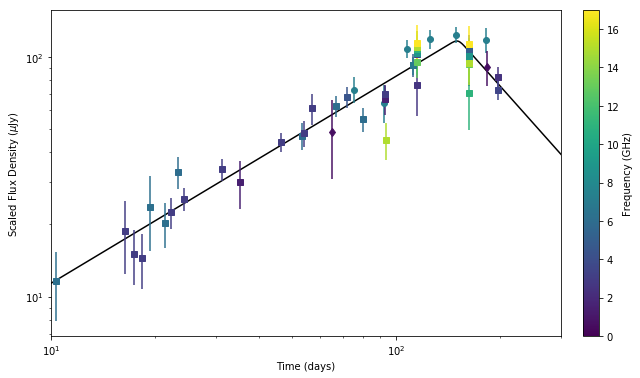

In [21]:
def plot_model(model, params, tvals, ax):
    best_fit = model(tvals, 3.0, *params)
    
    ax.plot(tvals,best_fit,marker='',linestyle='-',c='k',linewidth=1.5,zorder=0)

    return

args = []
for param in param_names:
    val = best_params[param][0]
    args.append(val)

plotting_data = scale_data(tdata, best_params['alpha'][0],np.max(best_params['alpha'][1:]))    
    
make_plot(plotting_data,scaled=True,model=smooth_broken_power_law,params=args, plot_models=False)

But how do we know that the lightcurve has definitely turned over?

We can perform a similar process as above to fit a standard power law to our data and then use an F-test to determine which model (turnover or no turnover) provides the best fit. We have provided a power_law() function that calculates the a power-law fit to the data. Now write a series of functions to perform an MCMC fit using a standard power law; lnprior_noturnover(), lnlike_noturnover(), lnprob_noturnover(), get_starting_pos_noturnover(), run_mcmc_noturnover().

In [22]:
def power_law(t, nu, F0, delta_1, alpha, nu0=3.0):
    return (nu/nu0)**alpha * F0 * t**delta_1

def lnprior_noturnover(theta):
    F0, delta_1, alpha = theta

    if delta_1 > 0.0:
        return 0.0
    
    else:
        return -np.inf
    
def lnlike_noturnover(theta, t, nu, S, S_err):
    F0, delta_1, alpha = theta

    model = power_law(t, nu, F0, delta_1, alpha)
    inv_sigma2 = 1.0/S_err**2

    return -0.5*(np.sum((S-model)**2*inv_sigma2 - np.log(inv_sigma2)))

def lnprob_noturnover(theta, t, nu, S, S_err):
    lp = lnprior_noturnover(theta)

    if not np.isfinite(lp):
        return -np.inf

    return lp + lnlike_noturnover(theta, t, nu, S, S_err)

def get_starting_pos_noturnover(nwalkers, ndim=6):
    F0 = 10
    delta_1 = 0.8
    alpha = -0.6
    
    pos = [np.asarray([F0, delta_1, alpha]) + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
    
    return pos

def run_mcmc_noturnover(data, niters=1000, nthreads=1, nwalkers=200, ndim=3):
    t = data['delta_t']
    nu = data['frequency']
    S = data['flux']
    S_err = data['rms']
    
    pos = get_starting_pos_noturnover(nwalkers, ndim=ndim)
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_noturnover, args=(t, nu, S, S_err),threads=nthreads)
    
    start = timer()
    sampler.run_mcmc(pos, niters)
    end = timer()
    
    print("Computation time: %f s"%(end-start))
    
    return sampler

Now run the sampler for the standard power law fit and write a function to plot the chains and calculate the length of the burn-in.

In [23]:
sampler_noturnover = run_mcmc_noturnover(tdata)

Computation time: 77.228885 s


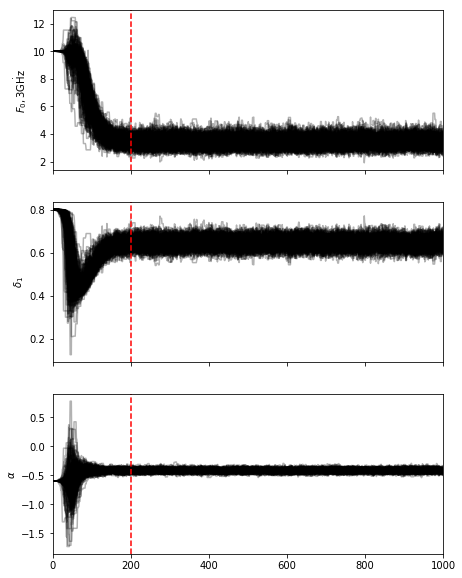

In [24]:
def make_chain_plot_noturnover(chain, chain_cut):
    niters = chain.shape[1]
    ndim = chain.shape[2]

    fig, axes = plt.subplots(ndim,1,sharex=True)
    fig.set_size_inches(7, 10)
    
    param_names = ['$F_{0}, 3\.{\\rm GHz}}$','$\\delta_1$', '$\\alpha$']

    for i, (ax,param_name) in enumerate(zip(axes,param_names)):
        ax.plot(chain[:,:,i].T,linestyle='-',color='k',alpha=0.3)
        ax.set_ylabel(param_name)
        ax.set_xlim(0,niters)
        ax.axvline(chain_cut,c='r',linestyle='--')

chain_noturnover = sampler_noturnover.chain
chain_cut_nt = 200

make_chain_plot_noturnover(chain_noturnover, chain_cut)

Make a corner plot for the standard power law fit

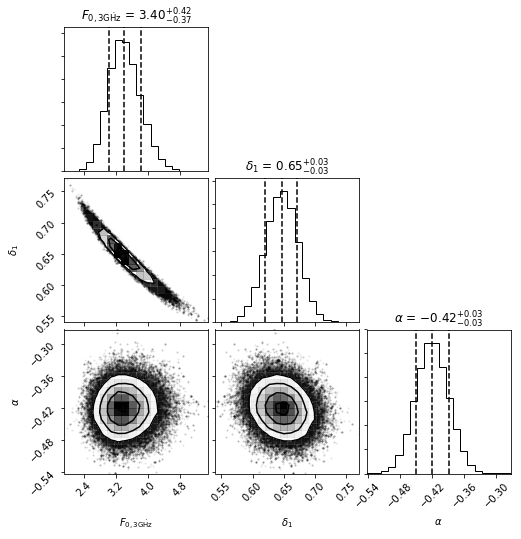

In [25]:
def make_corner_plot_noturnover(good_chain, savefile='corner.png'):
    param_names = ['$F_{0, 3\.{\\rm GHz}}$', '$\\delta_1$', '$\\alpha$']
    ndim = good_chain.shape[2]
    
    fig = corner.corner(good_chain.reshape((-1, ndim)), quantiles=[0.16, 0.5, 0.84], labels=param_names, show_titles=True)
    plt.savefig(savefile)

good_chain_nt = chain_noturnover[:, chain_cut_nt:, :]

make_corner_plot_noturnover(good_chain_nt)

How do the values of $\delta_1$ and $\alpha$ compare to the previous fit. How does the calculated radio spectral index compare to the joint X-ray/radio spectral index ($\alpha=-0.585\pm 0.005$)?

Now write a function to get the best parameters for the standard power law fit.

In [26]:
def get_best_params_noturnover(chain):
    ndim = chain.shape[2]
    
    chain = chain.reshape((-1, ndim))
    vals = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(chain, [16, 50, 84],axis=0)))
    
    param_names = ['F0', 'delta_1', 'alpha']
    
    param_dict = dict(zip(param_names,vals))
    
    return param_dict
    
    
best_params_nt = get_best_params_noturnover(good_chain_nt)

Now that we have the best parameters for the standard power law fit we can plot it over our data. Don't forget to scale the data based on the calculated best-fit spectral index!

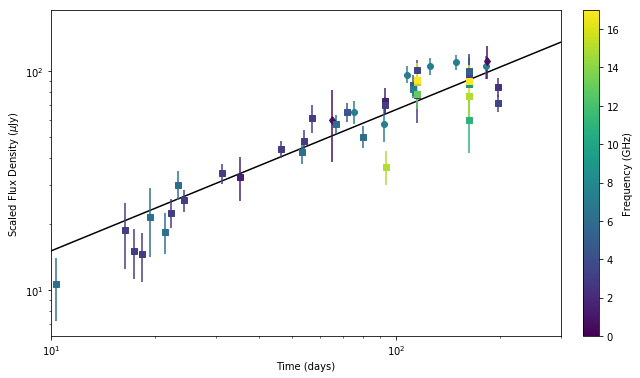

In [27]:
param_names_nt = ['F0', 'delta_1', 'alpha']
args_nt = []
for param in param_names_nt:
    val = best_params_nt[param][0]
    args_nt.append(val)
        


plotting_data_nt = scale_data(tdata, best_params_nt['alpha'][0],np.max(best_params_nt['alpha'][1:]))    
    
make_plot(plotting_data_nt,scaled=True,model=power_law,params=args_nt)

Calculate the $\chi^2$ for the standard power law fit. We will then use this, and the previously calculated $\chi^2$ to perform an F-test and determine which model we prefer.

In [28]:
chi2_nt = calc_chi2(best_params_nt, ['F0', 'delta_1', 'alpha'], power_law, tdata)
print(chi2_nt)

122.909101979116


An [F-test](https://en.wikipedia.org/wiki/F-test) is a generalised test that can be used to compare statistical models. In particular, it is useful when comparing two models where one is a restricted form of the other. Write a function calculate_ftest that calculates the F statistic for our two fits and then calculates the corresponding p-value. Hint: We have already imported the [scipy.stats F-distribution model](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f.html), and we can access the cumulative distribution function using f.cdf().

In [29]:
def calculate_ftest(chi2_t, p_t, chi2_nt, p_nt, n):
    F = ((chi2_nt-chi2_t)/chi2_t) * (n-p_t)/(p_t-p_nt)
    
    pval = f.cdf(F, p_nt, p_t)
    
    return 1-pval

n = len(tdata)
p_t = 6
p_nt = 3

calculate_ftest(chi2_best, p_t, chi2_nt, p_nt, n)

0.002572869575720116

Which model is preferred? With what confidence can we say that we prefer one model over the other?

## Determining Lightcurve Parameters
We're now going to use the full radio lightcurve to determine the best fitting parameters for the smooth broken power law. Load the full dataset and pass it to your previous run_mcmc() function.

In [30]:
data = load_data()

full_sampler = run_mcmc(data)
full_chain = full_sampler.chain

/home/chummels/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in power
  after removing the cwd from sys.path.


Computation time: 101.271144 s


Plot the chain and estimate the burn-in length

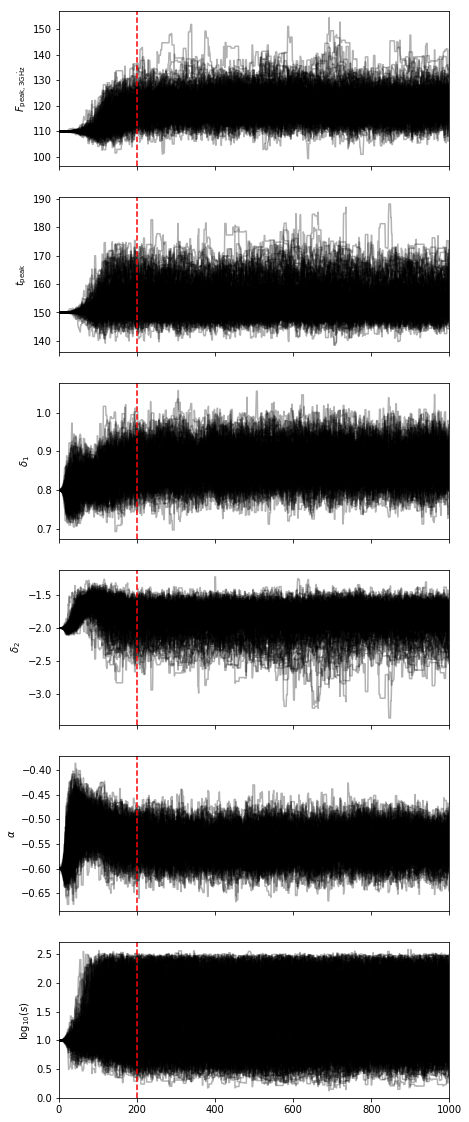

In [31]:
full_chain_cut = 200

make_chain_plot(full_chain, full_chain_cut)

Make a corner plot

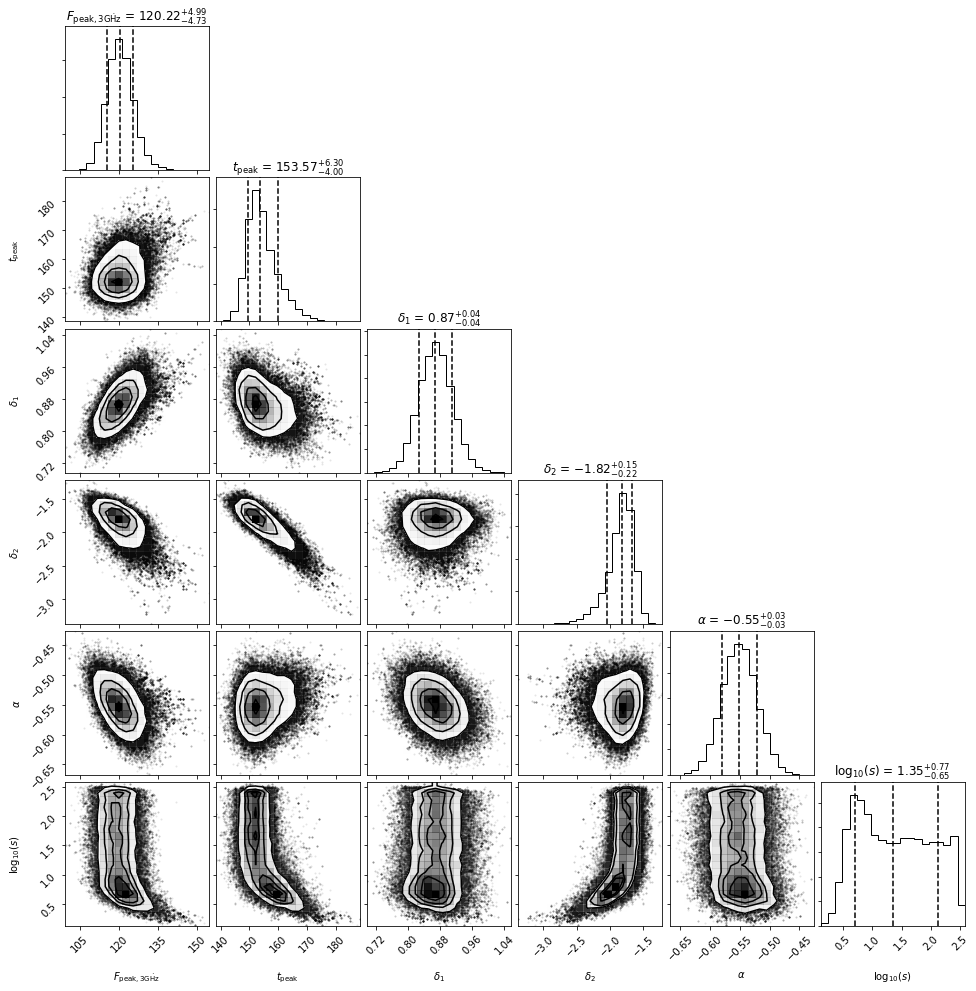

In [32]:
good_full_chain = full_chain[:, full_chain_cut:, :]
make_corner_plot(good_full_chain, savefile='corner_fulldata.png')

Calculate the best parameters and the $\chi^2$ for the best fit.

In [33]:
full_params = get_best_params(good_full_chain)
plotting_data = scale_data(data, full_params['alpha'][0],np.max(full_params['alpha'][1:]))

chi2_full = calc_chi2(full_params, param_names, smooth_broken_power_law, plotting_data)

print(chi2_full)

76.26620151526585


Now plot the full lightcurve. A physically motivated model of a relativistic jet and cocoon of ejecta can also be overplotted by using passing "plot_models=True" to the make_plot function.

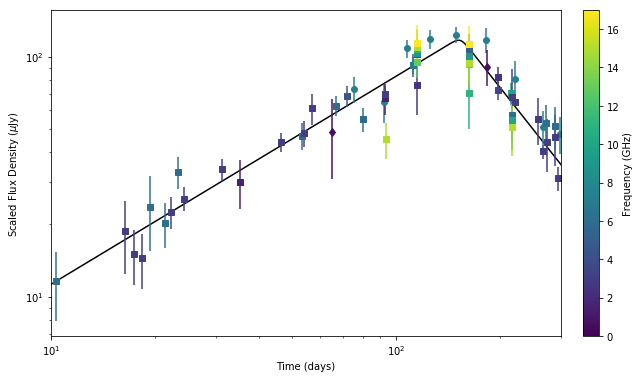

In [34]:
full_args = []

for param in param_names:
    val = full_params[param][0]
    full_args.append(val)
    
make_plot(plotting_data,scaled=True,model=smooth_broken_power_law,params=full_args)

Now write a function to plot the best fitting model for the 3 GHz data and call it from your make_plot() function when you pass plot_models=True

In [35]:
def plot_physical_models(ax, fname='jet_cocoon_contribution.txt'):
    data = ascii.read(fname)
    
    ax.plot(data['t'], data['cocoon']+data['jet'], label='Narrow Jet + Cocoon', c='r', linestyle='--')
    
    return ax

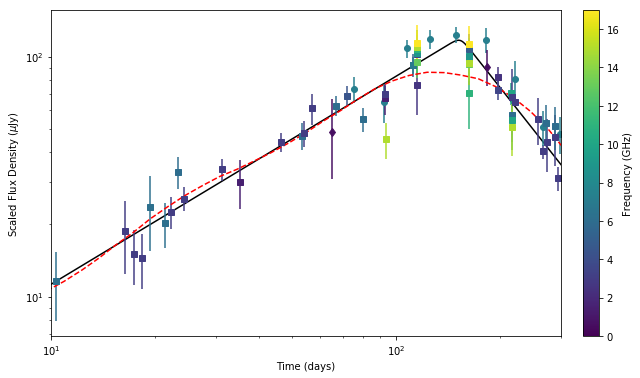

In [36]:
make_plot(plotting_data, scaled=True, model=smooth_broken_power_law, params=full_args, plot_models=True)